In [1]:
"""
All tastes stacked
Different lambdas for each taste but same tau
SINGLE NEURON
"""

'\nAll tastes stacked\nDifferent lambdas for each taste but same tau\nSINGLE NEURON\n'

In [2]:
# Import stuff
import os
import scipy
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import theano

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

os.chdir('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

In [3]:
data_dir = '/media/bigdata/Abuzar_Data/AS18/AS18_4Tastes_200229_154608'
dat = \
    ephys_data(data_dir)
dat.firing_rate_params = dict(zip(\
    ('type', 'step_size','window_size','dt', 'baks_resolution', 'baks_dt'),
    ('conv',1,250,1,1e-3,1e-3)))

dat.get_unit_descriptors()
dat.get_spikes()
dat.get_firing_rates()
print(np.array(dat.spikes).shape)

All tastes have equal dimensions,concatenating and normalizing
(4, 30, 31, 7000)


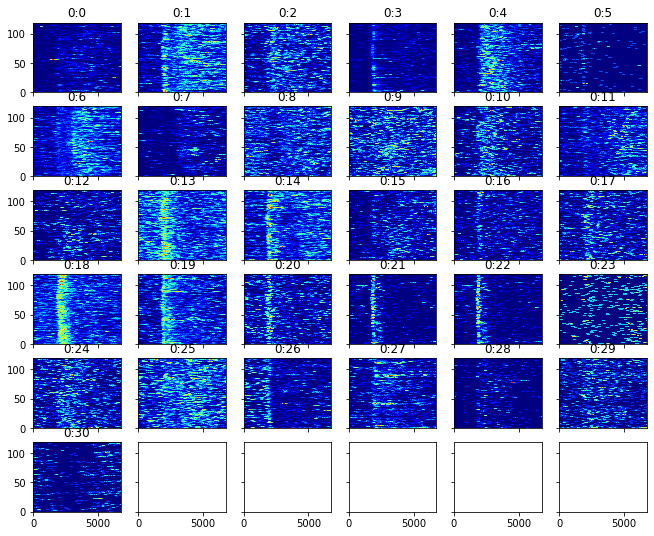

In [4]:
visualize.firing_overview(dat.all_normalized_firing);

(4, 30, 7000)


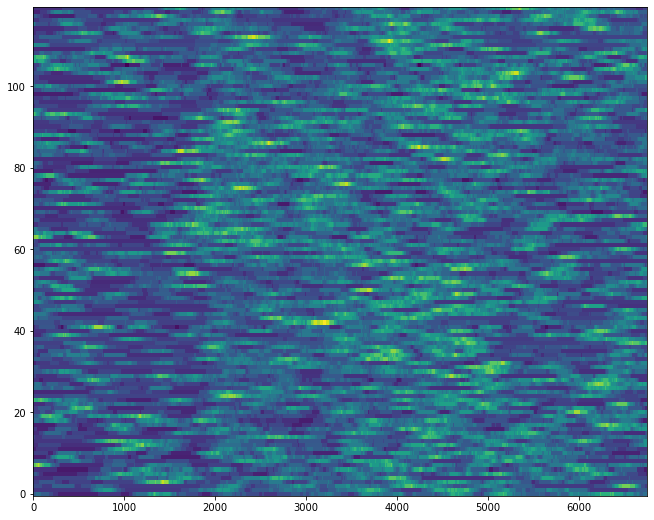

In [151]:
nrn = 25
taste_dat = np.array(dat.spikes)[:,:,nrn]
#taste_dat = np.array(dat.spikes)[:,:,nrn]
print(taste_dat.shape)
visualize.imshow(stats.zscore(dat.all_normalized_firing[nrn],axis=1))

In [152]:
# Convert spikes to counts by binning
time_lims = [2000,4000]
bin_width = 25
t_vec = np.arange(taste_dat.shape[-1])
binned_t_vec = np.mean(t_vec[time_lims[0]:time_lims[1]].reshape((-1,bin_width)),axis=-1)
this_dat_binned = np.sum(taste_dat[...,time_lims[0]:time_lims[1]].reshape(*taste_dat.shape[:-1],-1,bin_width),axis=-1)
this_dat_binned = np.vectorize(np.int)(this_dat_binned)

print(this_dat_binned.shape)

(4, 30, 80)


(4, 80)


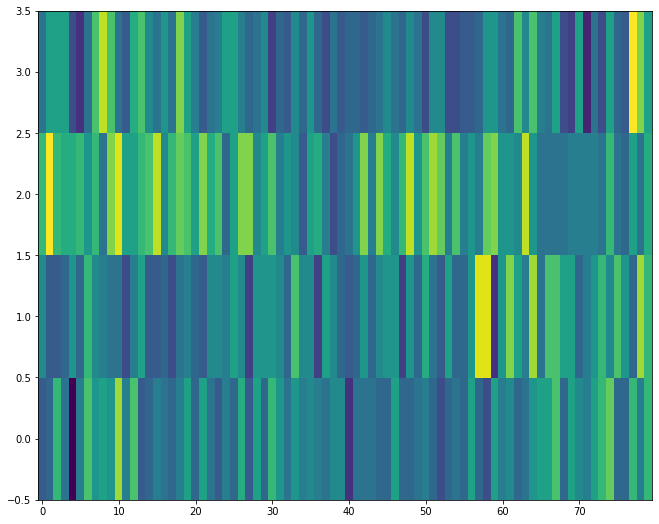

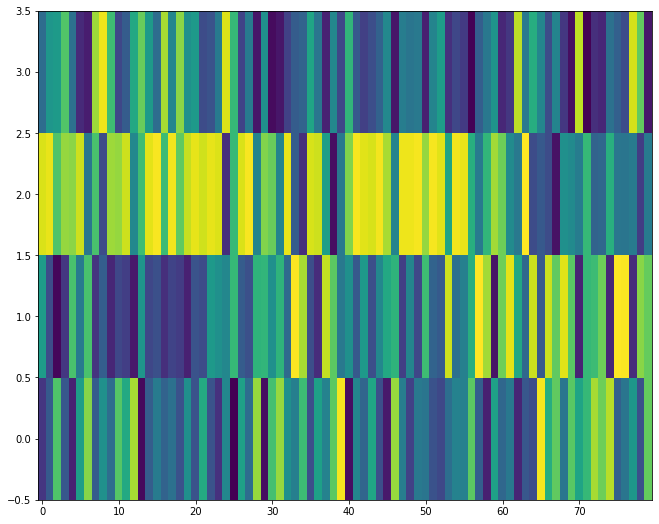

In [153]:
zscore_this_dat = np.array([stats.zscore(np.mean(nrn,axis=0),axis=None) \
                            for nrn in this_dat_binned.swapaxes(0,2)]).swapaxes(0,1)
mean_this_dat = np.mean(this_dat_binned,axis=1)
print(zscore_this_dat.shape)
visualize.imshow(mean_this_dat);
plt.figure();
visualize.imshow(zscore_this_dat);

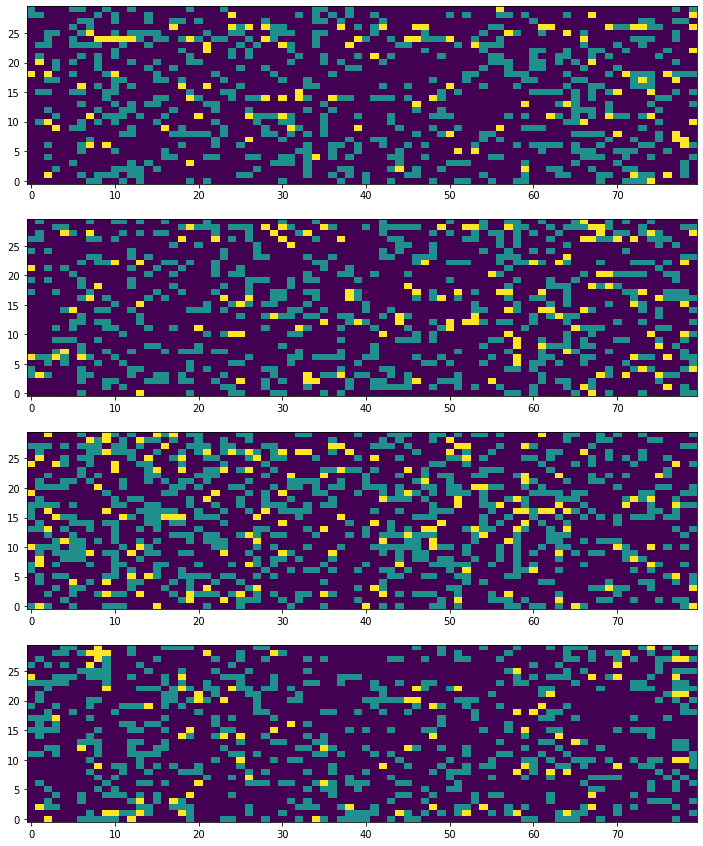

In [154]:
# Pick single trial
trial = np.arange(taste_dat.shape[1])
taste = np.arange(taste_dat.shape[0])

all_iters = np.ndindex(this_dat_binned.shape[:1])

fig, ax = plt.subplots(len(taste), figsize = (12,15))
for this_ax, this_iter in zip(ax.flatten(),all_iters):
    this_dat = this_dat_binned[this_iter]
    this_ax.imshow((this_dat>0)*1 + (this_dat>1), interpolation = 'nearest', aspect = 'auto', origin = 'lower')
fig.savefig('binned_raster')

#count_data = count_data>0
#print(count_data.shape)
# Nrn X Time_bin

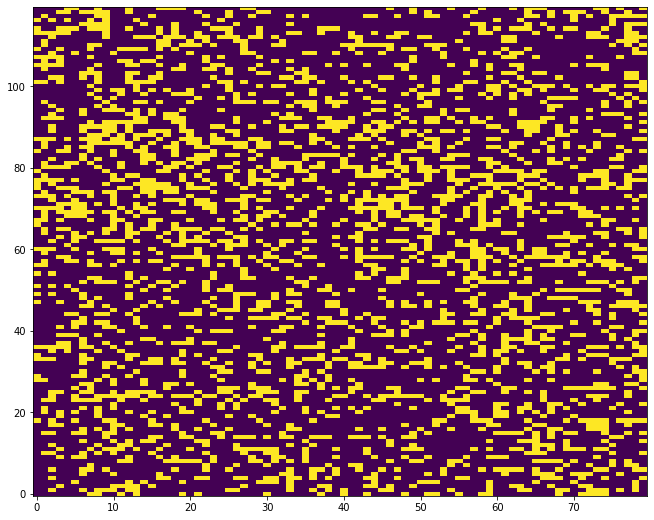

In [155]:
this_dat_long = np.reshape(this_dat_binned, (-1,this_dat_long.shape[-1]))
this_dat_long[this_dat_long>1] = 1
plt.imshow(this_dat_long,aspect='auto',origin='lower');

In [160]:
states = 3
tastes = this_dat_binned.shape[0]
split_list = np.array_split(this_dat_binned,states,axis=-1)
# Cut all to the same size
min_val = min([x.shape[-1] for x in split_list])
split_array = np.array([x[...,:min_val] for x in split_list])
print(split_array.shape)
mean_vals = np.mean(split_array,axis=(2,-1)).swapaxes(0,1)
mean_vals += 0.01 # To avoid zero starting prob
print(mean_vals.shape) # Trials x nrns
print(mean_vals)

(3, 4, 30, 26)
(4, 3)
[[0.27410256 0.25230769 0.30102564]
 [0.25487179 0.26128205 0.32923077]
 [0.39846154 0.34717949 0.31384615]
 [0.30615385 0.24205128 0.27153846]]


In [161]:
idx = np.arange(this_dat_long.shape[-1]) # Index
array_idx = np.broadcast_to(idx, this_dat_long.shape)
idx_range = idx.max() - idx.min()
print(idx.min())
print(idx.max())
print(array_idx.shape)

0
79
(120, 80)


In [162]:
even_switches = np.linspace(0,idx.max(),states+1)
even_switches_normal = even_switches/np.max(even_switches)
print(even_switches)
print(even_switches_normal[1:(states)])

[ 0.         26.33333333 52.66666667 79.        ]
[0.33333333 0.66666667]


(4, 3)


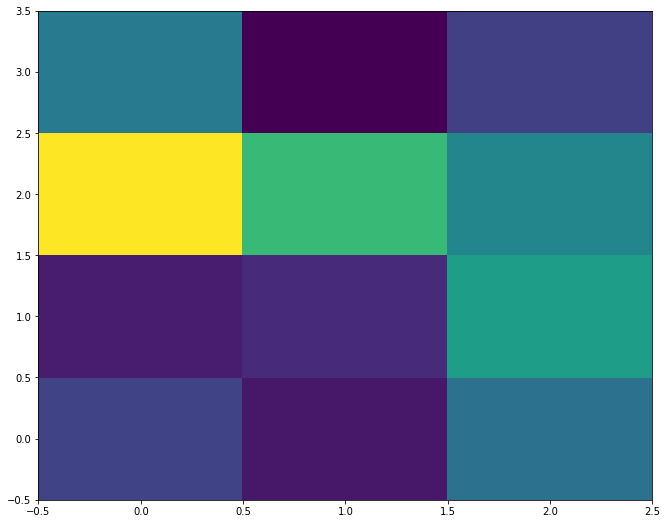

In [163]:
with pm.Model() as model:
    
    # SAME LAMBDAS ACROSS ALL TRIALS
    # Finite, but somewhere on the lower end, Beta prior
    a_lambda = 2
    b_lambda = 5
    
    lambda_latent = pm.Beta('lambda', a_lambda, b_lambda, 
                            testval = mean_vals, 
                            shape = (mean_vals.shape))
    
print(lambda_latent.tag.test_value.shape)

plt.imshow(lambda_latent.tag.test_value, aspect = 'auto', origin='lower');

In [164]:
print(array_idx.shape)

(120, 80)


In [165]:
trial_num = array_idx.shape[0]

with model:
    
    # INDEPENDENT TAU FOR EVERY TRIAL
    a = pm.HalfNormal('a_tau', 3., shape = states - 1)
    b = pm.HalfNormal('b_tau', 3., shape = states - 1)
    
    # Stack produces states x trials --> That gets transposed to trials x states and gets sorted along states (axis=-1)
    # Sort should work the same way as the Ordered transform --> see rv_sort_test.ipynb

    tau_latent = pm.Beta('tau_latent', a, b, 
                           shape = (trial_num, states-1)).sort(axis=-1)
       
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)

print(tau.tag.test_value.shape)
tau_test_value = tau.tag.test_value

(120, 2)


In [166]:
with model:
    
    # Assign lambdas to time_bin indices using sigmoids centered on switchpoints
    # Refer to https://www.desmos.com/calculator/yisbydv2cq
    
    weight_1_stack = tt.nnet.sigmoid(array_idx - tau[...,0][...,np.newaxis])
    weight_2_stack = tt.nnet.sigmoid(array_idx - tau[...,1][...,np.newaxis])
    
print(weight_1_stack.tag.test_value.shape)
print(lambda_latent.tag.test_value.shape)

(120, 80)
(4, 3)


In [167]:
test = tt.extra_ops.repeat(lambda_latent,30,axis=0)[:,0]
print(test.tag.test_value.shape)

(120,)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3]
(120, 80)
(120, 80)


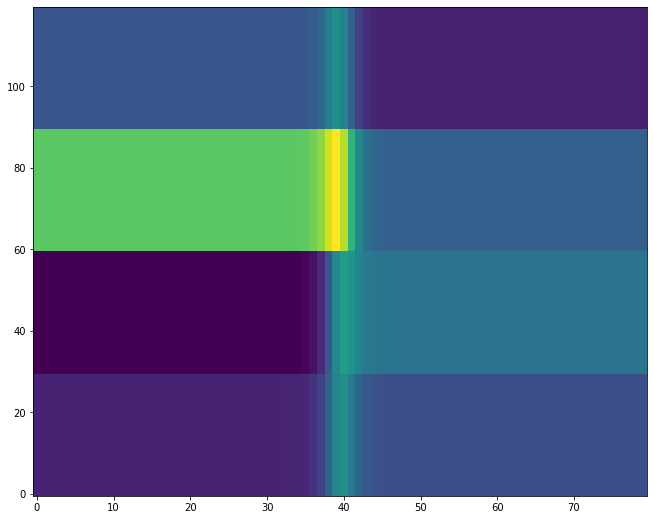

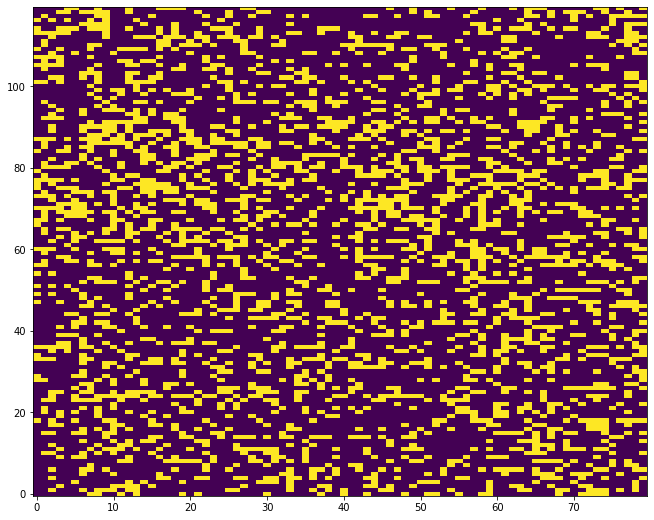

In [169]:
with model:
    
    taste_label = np.repeat([0,1,2,3],30)
    
    lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[taste_label,0][:,np.newaxis]) + \
                np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[taste_label][:,1][:,np.newaxis]) + \
                np.multiply(weight_2_stack, lambda_latent[taste_label,2][:,np.newaxis])               

print(taste_label)
print(weight_1_stack.tag.test_value.shape)
print(lambda_.tag.test_value.shape)
visualize.imshow(lambda_.tag.test_value)
plt.figure()
visualize.imshow(this_dat_long)

In [170]:
# Using Bernoullo likelihood for count data
with model:
    observation = pm.Bernoulli("obs", lambda_, observed=this_dat_long)

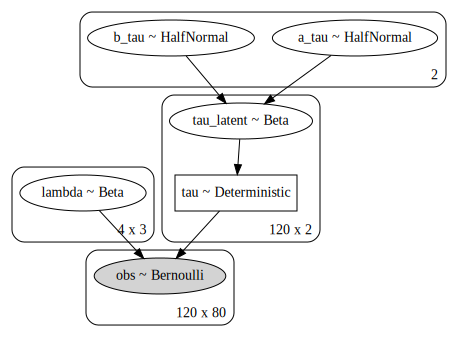

In [171]:
pm.model_to_graphviz(model)

In [196]:
with model:
    step= pm.Metropolis()
    #step= pm.NUTS()
    trace = pm.sample(10000, tune=2500, 
                      step = step,
                      chains = 4, cores = 4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_latent]
>Metropolis: [b_tau]
>Metropolis: [a_tau]
>Metropolis: [lambda]
Sampling 4 chains, 0 divergences:   0%|          | 0/50000 [00:00<?, ?draws/s]/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval 

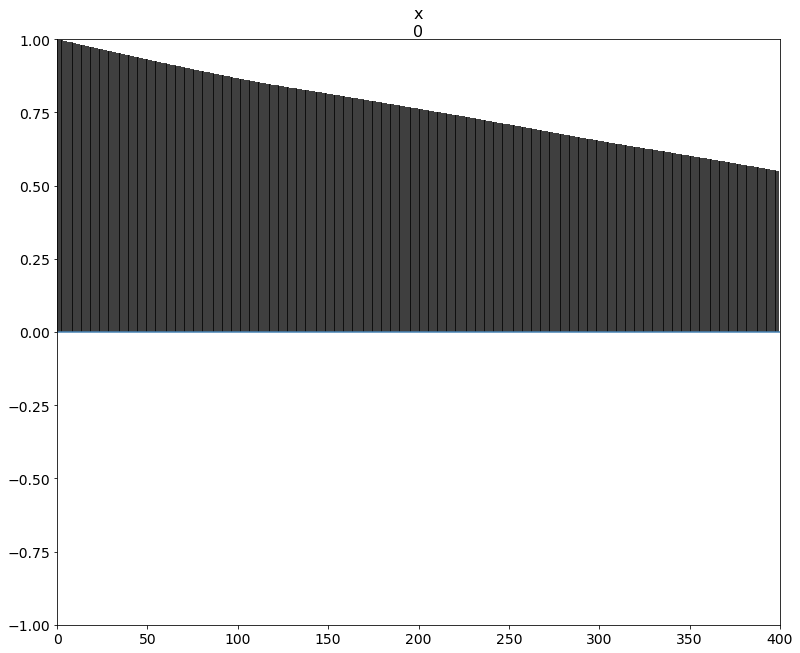

In [197]:
pm.autocorrplot(trace['tau_latent'][:,0,0],max_lag = 400);

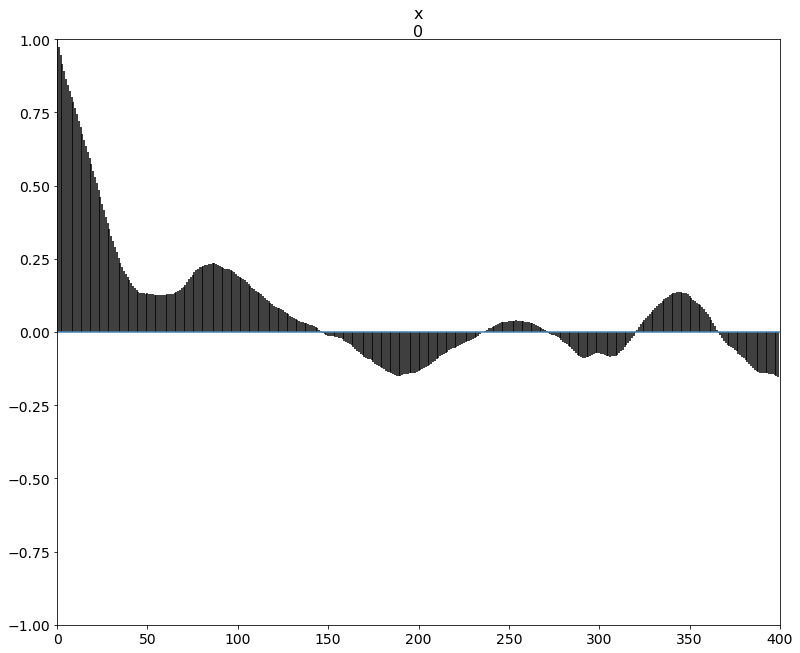

In [198]:
pm.autocorrplot(trace['tau_latent'][::20,0,0],max_lag = 400);

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


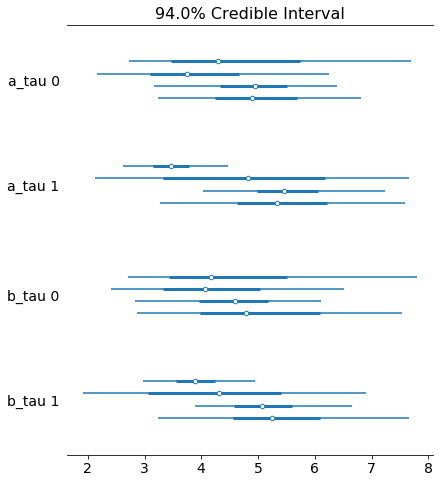

In [199]:
pm.forestplot(trace, var_names = ['a_tau','b_tau']);

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


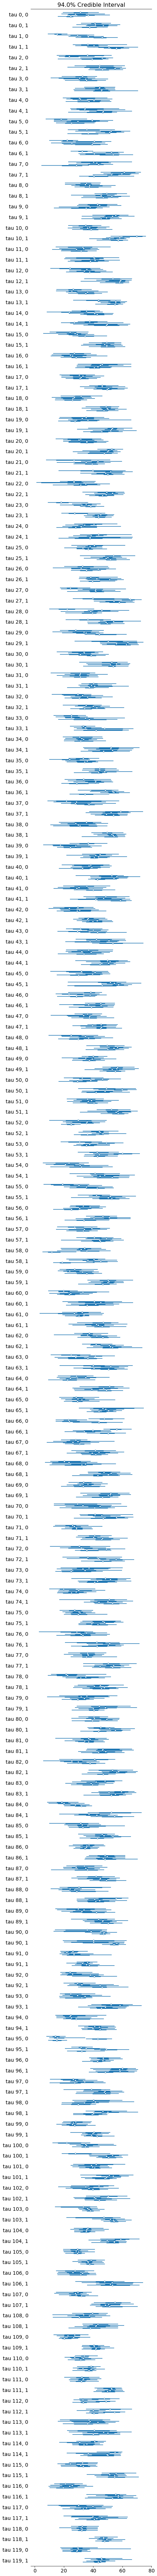

In [200]:
pm.forestplot(trace[::100], var_names = 'tau');

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


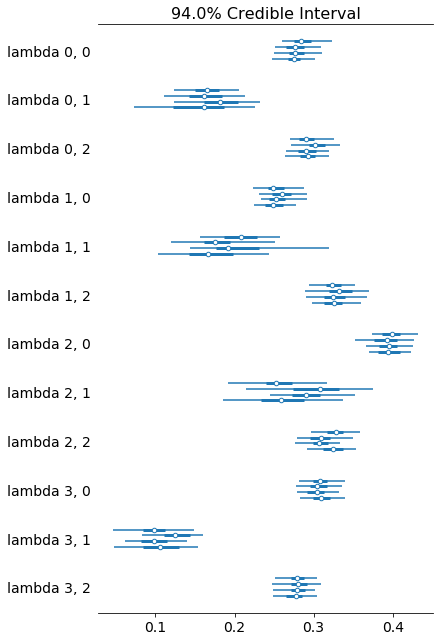

In [201]:
pm.forestplot(trace[::100], var_names = ['lambda']);

In [178]:
lambda_stack = trace['lambda'].swapaxes(0,1)
tau_samples = trace['tau']
print(tau_samples.shape)
print(lambda_stack.shape)

(4000, 120, 2)
(4, 4000, 3)


In [179]:
trial_ind = (0,0)
mean_trial_tau = np.mean(tau_samples,axis=0)[trial_ind]
print(mean_trial_tau)
print(tau_test_value[trial_ind])

32.83959607112683
39.5


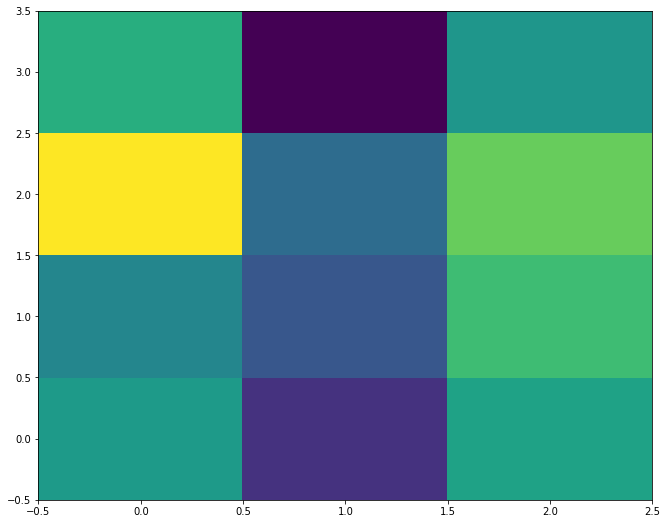

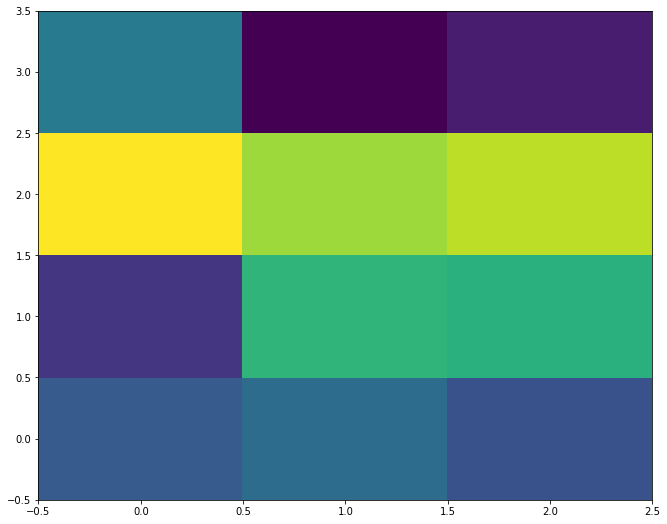

In [182]:
mean_lambda = np.mean(lambda_stack,axis=1)
visualize.imshow(mean_lambda)

plt.figure();
visualize.imshow(stats.zscore(mean_lambda,axis=0))

In [183]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)
ppc['obs'].shape

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
  0%|          | 0/2000 [00:00<?, ?it/s]/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100%|██████████| 2000/2000 [00:04<00:00, 494.30it/s]


(2000, 120, 80)

(120, 80)


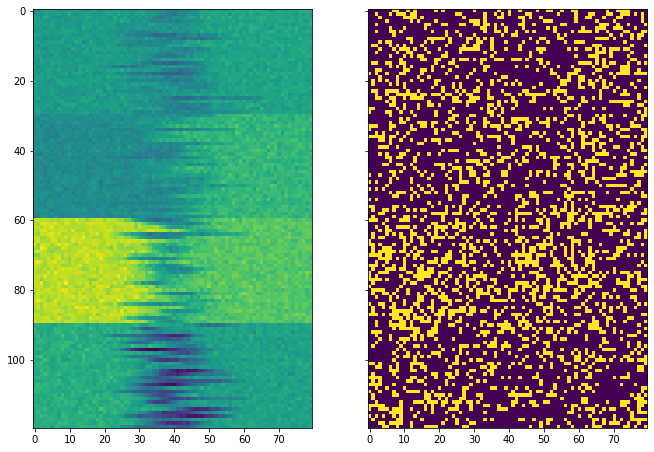

In [193]:
mean_ppc = np.mean(ppc['obs'],axis=0)
std_ppc = np.std(ppc['obs'],axis=0)
print(mean_ppc.shape)
fig, ax = plt.subplots(1,2,sharey=True);
ax[0].imshow(mean_ppc);
ax[1].imshow(this_dat_long);

In [186]:
mean_mean_tau = np.mean(tau_samples,axis=(0,1))
mean_mean_ppc = np.mean(mean_ppc,axis=0)
print(mean_mean_tau.shape)
print(mean_mean_ppc.shape)

(2,)
(80,)


In [ ]:
tick_interval = 10
fig,ax = plt.subplots(mean_mean_tau.shape[0],3, sharex = 'all')

for this_ax, this_dat in zip(ax[:,0], mean_mean_ppc):
    this_ax.imshow(this_dat, aspect='auto', origin='lower')
for this_ax, this_dat in zip(ax[:,1], zscore_mean_mean_ppc):
    this_ax.imshow(this_dat, aspect='auto', origin='lower')
    
long_tau_samples = tau_samples.swapaxes(1,2).reshape((-1,tau_samples.shape[1], tau_samples.shape[-1]))
print(long_tau_samples.shape)
for this_ax, this_dat in zip(ax[:,-1], np.moveaxis(long_tau_samples,0,-1)):
    for switch in range(this_dat.shape[0]):
         this_ax.hist(this_dat[switch],bins = 100, density = True,alpha = 0.8)
    
for this_ax in ax[-1,:]:
    this_ax.set_xticks(np.arange(0,len(binned_t_vec),tick_interval));
    this_ax.set_xticklabels(binned_t_vec[::tick_interval],rotation='vertical');

In [ ]:
# Overlay raster with CDF of switchpoints
zscore_mean_ppc = np.stack([stats.zscore(mean_ppc[:,nrn],axis=None) for nrn in range(mean_ppc.shape[1])]).swapaxes(0,1)
fig, ax = plt.subplots(count_data.shape[0],4, figsize = (7,60),sharex=True)
for trial in range(count_data.shape[0]):
    ax[trial,0].imshow(count_data[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[trial,1].imshow(zscore_mean_ppc[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[trial,1].vlines(mean_tau[trial],-0.5,count_data.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)

    #fin_prob,this_x = np.histogram(tau_samples[:,trial].flatten(),100)
    #cum_prob = np.cumsum(fin_prob)
    #ax[trial,0].plot(this_x[1:],(cum_prob/np.max(cum_prob)*count_data.shape[1])-0.5, c = 'red');
    for state in range(tau_samples.shape[-1]):
        ax[trial,2].hist(tau_samples[:,trial,state], bins = 100, density = True)
    ax[trial,0].vlines(mean_tau[trial],-0.5,count_data.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
    ax[trial,3].hist2d(tau_samples[:,trial,0],tau_samples[:,trial,1],30)

for col in range(2):
    plt.sca(ax[-1,col])
    plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
    plt.xlim(0,len(binned_t_vec))